In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# Model
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score ,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection
from sklearn.preprocessing import Binarizer

In [3]:
df_good = pd.read_csv('./dataset/data_확장기.csv')
df_bad = pd.read_csv('./dataset/data_수축기.csv')
df_change = pd.read_csv('./dataset/data_전환기.csv')
df_all = pd.read_csv('./dataset/data_전체.csv')

df_good.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_bad.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_change.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_all.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)

#### 함수

##### train, test 분리, 데이터 불균형 처리, 스케일링

In [4]:
def data(df):
    # scaler : StandardScaler(), RobustScaler()

    features = df.drop(['target'], axis=1)
    target = df['target']

    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=121, stratify=target, test_size=0.2)
    
    X_train, y_train = BorderlineSMOTE(random_state=121, sampling_strategy = 'not majority').fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

##### 모델 평가

In [5]:
def score(y_test, pred):
    
    print('accuracy score : {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('precision score : {0:.3f}'.format(precision_score(y_test, pred)))
    print('recall score : {0:.3f}'.format(recall_score(y_test, pred)))
    print('f1 score : {0:.3f}'.format(f1_score(y_test, pred)))
    print('roc score : {0:.3f}'.format(roc_auc_score(y_test, pred)))
    
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='YlOrBr', fmt='g')
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)

In [6]:
def get_f1_score(y_test, pred_proba_1):
    thresholds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores=[]

    for threshold in thresholds:
        binarizer = Binarizer(threshold = threshold)
        pred_proba = binarizer.fit_transform(pred_proba_1)

        accuracy = accuracy_score(y_test, pred_proba)
        precision = precision_score(y_test, pred_proba)
        recall = recall_score(y_test, pred_proba)
        f1score = f1_score(y_test, pred_proba)
        auc_score=roc_auc_score(y_test, pred_proba)

        accuracys.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1score)
        auc_scores.append(auc_score)
    results = pd.DataFrame(data = {"Accuracy": accuracys, "Precision": precisions, "Recall": recalls, "F1 score": f1_scores,"Auc_Score":auc_scores}, index = thresholds)
    print(results)

##### 모델링

In [7]:
def LR(df):
    X_train, X_test, y_train, y_test = data(df)

    logistic = LogisticRegression()

    param_logit = {'penalty' : ['l1', 'l2'],
                   'C' : [0.001, 0.01, 0.1, 1, 10, 100],
                   'solver' : ['liblinear'],
                   'random_state' : [121],
                   'class_weight' : ['balanced']}

    gridsearch = GridSearchCV(logistic, param_grid = param_logit, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))


    # model_coef = pd.Series(best_model.best_estimator_.regressor_.coef_[0], df.drop(['target']).columns).sort_values(ascending=False)
    # model_coef

In [8]:
def DT(df):
    X_train, X_test, y_train, y_test = data(df)

    dt = DecisionTreeClassifier()
    param_dt = { 'criterion' : ['entropy'],   #giny : 속도 더 빠름, #엔트로피 : 균형적인 트리
                    'splitter' : ['best'],
                    'random_state' : [121],
                    'max_depth' : [5, 6, 7],
                    'min_samples_split' : [3, 5],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(dt, param_grid = param_dt, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

    return gridsearch.fit(X_train, y_train)

In [9]:
def SVM(df, kernel):
    X_train, X_test, y_train, y_test = data(df)

    svc = SVC()
    param_svc = {'C' : [0.1, 0.5, 1.0],
                    'kernel' : [kernel],
                    'gamma' : [0.01, 0.1, 1.0, 10.0],
                    'random_state' : [121],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(svc, param_grid = param_svc, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    pred = estimator.predict(X_test)
    # pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    # prediction = pd.concat([pred_probability, pred], axis = 1)
    # prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    # pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    # print(get_f1_score(y_test, pred_proba_1))

In [10]:
def XGB(df):
    X_train, X_test, y_train, y_test = data(df)

    xgb = XGBClassifier()
    param_xgb={'booster' :['gbtree'],
               'silent' : [1],
               'verbosity' : [0],
               'learning_rate' : [0.01, 0.05, 0.1],    # 나중에 한 번 더 확인
               'n_estimators' : [500],
               'min_child_weight' : [3, 5, 7],  ###
               'gamma' : [0.1, 1.0, 10.0],    ###
               'max_depth' : [4, 6],     ###
               'objective':['binary:logistic'],
               'colsample_bytree' : [0.6, 0.8],
               'colsample_bylevel' : [0.6, 0.8],
               'random_state' : [121],
               'scale_pos_weight' : [ len(df[df['target']==0])/len(df[df['target']==1]) ]
                }

    gridsearch = GridSearchCV(xgb, param_grid = param_xgb, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)
    
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

#### Feature Selection

In [11]:
rfe_good = df_good[['유동비율', 'OCF', '총자본경상이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '유형자산증가율', '순이익증가율', 'target']]
sfm_rf_good = df_good[['부채비율', 'OCF', '총자산이익률', '총자본경상이익률', '자기자본순이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '순이익증가율', 'target']]
sfm_lr_good = df_good[['자기자본비율', '차입금의존도', '총자산이익률', '총자본경상이익률', '자기자본영업이익률', '매출원가율', '총자본회전율', '총자본증가율', '유형자산증가율', 'target']]
sfm_pi_good = df_good[['자기자본영업이익률', '총자본회전율', '총자산이익률', '총자본경상이익률', '순이익증가율', '자기자본회전율', '유동비율', 'OCF', 'target']]

In [12]:
rfe_bad = df_bad[['유동비율', 'OCF', '총자본경상이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', 'target']]
sfm_rf_bad = df_bad[['부채비율', 'OCF', '총자산이익률', '총자본경상이익률', '자기자본순이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '순이익증가율', 'target']]
sfm_lr_bad = df_bad[['자기자본비율', '유동비율', '차입금의존도', '자기자본영업이익률', '매출원가율', '총자본회전율', '자기자본회전율', '총자본증가율', '유형자산증가율', 'target']]
sfm_pi_bad = df_bad[['자기자본영업이익률', '총자본회전율', '총자본경상이익률', '총자산이익률', '순이익증가율', '자기자본회전율', '유동비율', 'OCF', 'target']]

#### 확장기

##### Recursive Feature Elimination

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8630189400899605

예측 데이터 정확도
accuracy score : 0.809
precision score : 0.338
recall score : 0.843
f1 score : 0.483
roc score : 0.824


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.58350    0.19812 0.96612   0.32881    0.75223
0.30000   0.68148    0.24097 0.93789   0.38343    0.79455
0.40000   0.75621    0.28963 0.90088   0.43834    0.82000
0.50000   0.80927    0.33820 0.84253   0.48266    0.82394
0.60000   0.84631    0.38469 0.75972   0.51075    0.80813
0.70000   0.86764    0.41441 0.61355   0.49469    0.75559
0.80000   0.87565    0.41388 0.42660   0.42014    0.67764
0.90000   0.87970    0.37556 0.21016   0.26951    0.58445
None


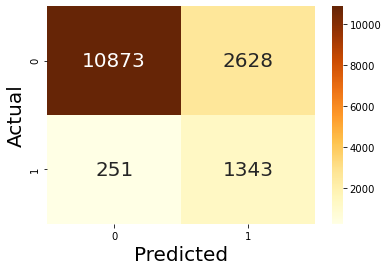

In [13]:
LR(rfe_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9203861675012197

예측 데이터 정확도
accuracy score : 0.873
precision score : 0.449
recall score : 0.901
f1 score : 0.600
roc score : 0.885
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.85041    0.41032 0.95295   0.57364    0.89563
0.30000   0.86452    0.43420 0.93350   0.59271    0.89494
0.40000   0.86645    0.43743 0.92535   0.59404    0.89242
0.50000   0.87300    0.44945 0.90088   0.59971    0.88530
0.60000   0.88029    0.46316 0.84003   0.59710    0.86254
0.70000   0.88062    0.46154 0.78294   0.58074    0.83755
0.80000   0.89513    0.50271 0.64053   0.56331    0.78286
0.90000   0.90414    0.56120 0.42284   0.48229    0.69190
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

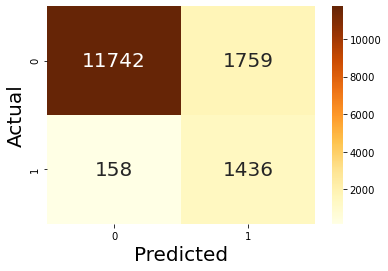

In [14]:
DT(rfe_good)

In [15]:
# SVM(rfe_good, 'rbf')

In [16]:
# XGB(rfe_good)

##### SelectFromModel_RandomForest

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8635014510193993

예측 데이터 정확도
accuracy score : 0.811
precision score : 0.342
recall score : 0.854
f1 score : 0.489
roc score : 0.830
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.58417    0.19822 0.96487   0.32888    0.75204
0.30000   0.68095    0.24058 0.93726   0.38288    0.79398
0.40000   0.75588    0.28934 0.90088   0.43801    0.81982
0.50000   0.81139    0.34239 0.85383   0.48878    0.83011
0.60000   0.84750    0.38625 0.75408   0.51084    0.80630
0.70000   0.86890    0.41720 0.60853   0.49502    0.75408
0.80000   0.87698    0.41967 0.43099   0.42526    0.68031
0.90000   0.88175    0.39494 0.22522   0.28686    0.59224
None


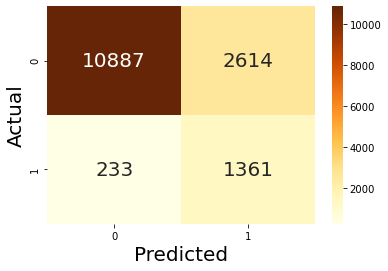

In [17]:
LR(sfm_rf_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9203334697419499

예측 데이터 정확도
accuracy score : 0.876
precision score : 0.455
recall score : 0.898
f1 score : 0.604
roc score : 0.886
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.84644    0.40418 0.95797   0.56850    0.89562
0.30000   0.86154    0.42865 0.93476   0.58777    0.89383
0.40000   0.86327    0.43177 0.93287   0.59031    0.89396
0.50000   0.87572    0.45518 0.89837   0.60422    0.88571
0.60000   0.87883    0.45980 0.84316   0.59509    0.86310
0.70000   0.88440    0.47100 0.76913   0.58423    0.83357
0.80000   0.89526    0.50313 0.65558   0.56933    0.78957
0.90000   0.90222    0.60424 0.21455   0.31667    0.59898
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

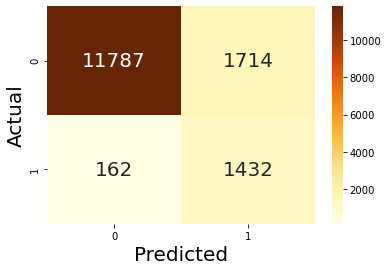

In [18]:
DT(sfm_rf_good)

In [19]:
# SVM(sfm_rf_good, 'rbf')

In [20]:
# XGB(sfm_rf_good)

##### SelectFromModel_Logistic Regression

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8376163529559622

예측 데이터 정확도
accuracy score : 0.803
precision score : 0.331
recall score : 0.854
f1 score : 0.477
roc score : 0.825
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.52189    0.17938 0.98683   0.30358    0.72691
0.30000   0.65598    0.22993 0.96110   0.37108    0.79053
0.40000   0.74621    0.28361 0.91970   0.43354    0.82271
0.50000   0.80258    0.33130 0.85383   0.47738    0.82518
0.60000   0.84346    0.37782 0.74592   0.50158    0.80045
0.70000   0.85876    0.38087 0.53952   0.44652    0.71799
0.80000   0.86433    0.35411 0.34567   0.34984    0.63562
0.90000   0.87261    0.31286 0.17252   0.22240    0.56389
None


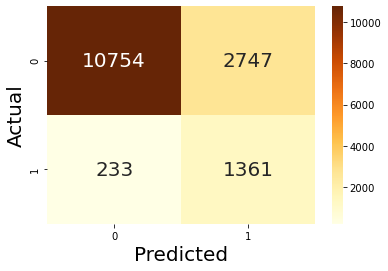

In [21]:
LR(sfm_lr_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9064744221874855

예측 데이터 정확도
accuracy score : 0.833
precision score : 0.383
recall score : 0.962
f1 score : 0.548
roc score : 0.890
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80815    0.35488 0.99875   0.52368    0.89220
0.30000   0.82392    0.37429 0.99373   0.54377    0.89880
0.40000   0.83259    0.38335 0.96173   0.54819    0.88954
0.50000   0.83259    0.38335 0.96173   0.54819    0.88954
0.60000   0.84200    0.39534 0.93726   0.55611    0.88401
0.70000   0.86240    0.42639 0.87767   0.57395    0.86913
0.80000   0.89109    0.48933 0.71895   0.58232    0.81518
0.90000   0.90527    0.56366 0.45546   0.50382    0.70692
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

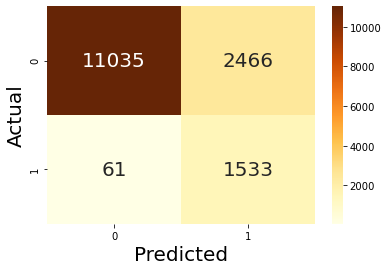

In [22]:
DT(sfm_lr_good)

In [23]:
# SVM(sfm_lr_good, 'rbf')

In [24]:
# XGB(sfm_lr_good)

##### Permutation Importance

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8620281069347175

예측 데이터 정확도
accuracy score : 0.811
precision score : 0.340
recall score : 0.847
f1 score : 0.486
roc score : 0.827
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.58158    0.19715 0.96424   0.32737    0.75032
0.30000   0.68162    0.24105 0.93789   0.38353    0.79463
0.40000   0.75787    0.29127 0.90213   0.44036    0.82148
0.50000   0.81053    0.34039 0.84693   0.48561    0.82658
0.60000   0.84717    0.38686 0.76474   0.51380    0.81082
0.70000   0.86744    0.41300 0.60602   0.49123    0.75216
0.80000   0.87565    0.41409 0.42785   0.42086    0.67819
0.90000   0.88023    0.38111 0.21518   0.27506    0.58696
None


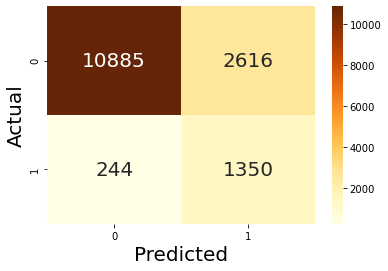

In [25]:
LR(sfm_pi_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9225566622892194

예측 데이터 정확도
accuracy score : 0.875
precision score : 0.453
recall score : 0.895
f1 score : 0.601
roc score : 0.884
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.85207    0.41301 0.95169   0.57604    0.89600
0.30000   0.86479    0.43531 0.94354   0.59576    0.89952
0.40000   0.87062    0.44549 0.92033   0.60037    0.89254
0.50000   0.87466    0.45273 0.89523   0.60135    0.88373
0.60000   0.88427    0.47219 0.81493   0.59793    0.85369
0.70000   0.88374    0.47020 0.79674   0.59139    0.84537
0.80000   0.89559    0.50379 0.75094   0.60302    0.83181
0.90000   0.89884    0.53300 0.33940   0.41472    0.65214
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

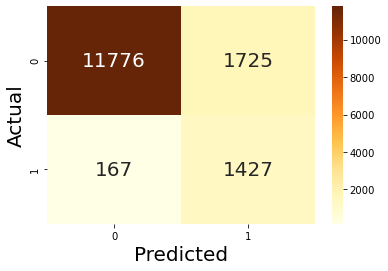

In [26]:
DT(sfm_pi_good)

In [27]:
# SVM(sfm_pi_good, 'rbf')

In [28]:
# XGB(sfm_pi_good)

#### 수축기

##### Recursive Feature Elimination

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8515896645819316

예측 데이터 정확도
accuracy score : 0.781
precision score : 0.263
recall score : 0.869
f1 score : 0.403
roc score : 0.821
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.49278    0.14154 0.97983   0.24735    0.71367
0.30000   0.62144    0.17831 0.95630   0.30058    0.77331
0.40000   0.71594    0.22093 0.92605   0.35675    0.81123
0.50000   0.78142    0.26270 0.86891   0.40343    0.82109
0.60000   0.83159    0.30708 0.77983   0.44065    0.80812
0.70000   0.85904    0.31434 0.55630   0.40170    0.72175
0.80000   0.87634    0.29790 0.33445   0.31512    0.63059
0.90000   0.89078    0.22830 0.11933   0.15673    0.54091
None


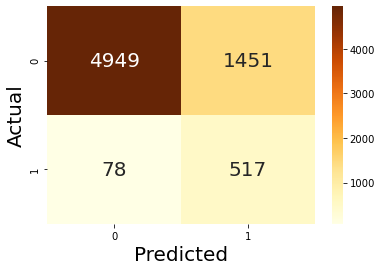

In [29]:
LR(rfe_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9058186858929578

예측 데이터 정확도
accuracy score : 0.841
precision score : 0.329
recall score : 0.840
f1 score : 0.473
roc score : 0.841
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80829    0.29903 0.93277   0.45288    0.86475
0.30000   0.80872    0.29755 0.91765   0.44938    0.85812
0.40000   0.83603    0.32598 0.86891   0.47409    0.85094
0.50000   0.84089    0.32938 0.84034   0.47326    0.84064
0.60000   0.84203    0.32724 0.81176   0.46644    0.82830
0.70000   0.84746    0.33262 0.78824   0.46783    0.82060
0.80000   0.89350    0.38462 0.42017   0.40161    0.67883
0.90000   0.89521    0.36417 0.31092   0.33545    0.63023
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

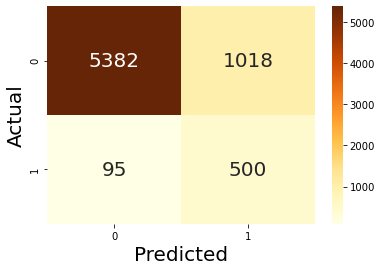

In [30]:
DT(rfe_bad)

In [31]:
# SVM(rfe_bad, 'rbf')

In [32]:
# XGB(rfe_bad)

##### SelectFromModel_RandomForest

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8550730703377454

예측 데이터 정확도
accuracy score : 0.793
precision score : 0.274
recall score : 0.864
f1 score : 0.416
roc score : 0.825
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.49764    0.14289 0.98151   0.24947    0.71708
0.30000   0.62802    0.18092 0.95630   0.30428    0.77690
0.40000   0.72795    0.22818 0.92269   0.36588    0.81627
0.50000   0.79328    0.27355 0.86387   0.41552    0.82529
0.60000   0.83817    0.31078 0.74118   0.43793    0.79418
0.70000   0.86362    0.32419 0.55630   0.40965    0.72425
0.80000   0.88034    0.31611 0.34958   0.33200    0.63963
0.90000   0.89350    0.25490 0.13109   0.17314    0.54773
None


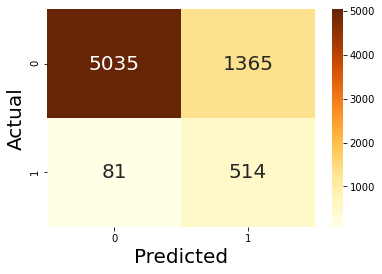

In [33]:
LR(sfm_rf_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9098225550453201

예측 데이터 정확도
accuracy score : 0.848
precision score : 0.341
recall score : 0.847
f1 score : 0.487
roc score : 0.848
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.81229    0.30699 0.95966   0.46517    0.87913
0.30000   0.81430    0.30828 0.95126   0.46565    0.87641
0.40000   0.84117    0.33733 0.89916   0.49060    0.86747
0.50000   0.84803    0.34146 0.84706   0.48672    0.84759
0.60000   0.85032    0.34349 0.83361   0.48651    0.84274
0.70000   0.87877    0.38100 0.68067   0.48854    0.78893
0.80000   0.88849    0.40454 0.65882   0.50128    0.78433
0.90000   0.90307    0.43423 0.46050   0.44698    0.70236
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

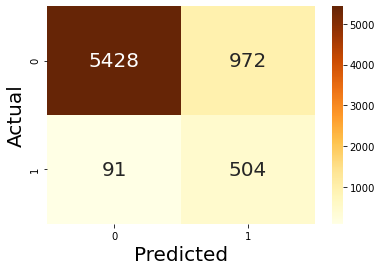

In [34]:
DT(sfm_rf_bad)

In [35]:
# SVM(sfm_rf_bad, 'rbf')

In [36]:
# XGB(sfm_rf_bad)

##### SelectFromModel_Logistic Regression

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8535702151925193

예측 데이터 정확도
accuracy score : 0.787
precision score : 0.270
recall score : 0.879
f1 score : 0.413
roc score : 0.829
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.44031    0.13062 0.98655   0.23069    0.68804
0.30000   0.59971    0.17197 0.97143   0.29221    0.76829
0.40000   0.71251    0.22126 0.94454   0.35853    0.81774
0.50000   0.78728    0.26973 0.87899   0.41279    0.82887
0.60000   0.82945    0.28914 0.68908   0.40735    0.76579
0.70000   0.85332    0.28557 0.48235   0.35875    0.68508
0.80000   0.86633    0.22131 0.22689   0.22407    0.57634
0.90000   0.88735    0.20489 0.11261   0.14534    0.53599
None


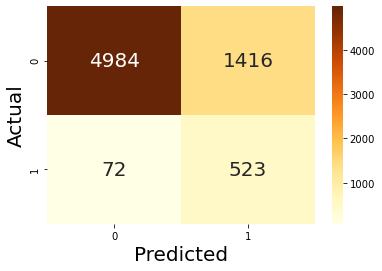

In [37]:
LR(sfm_lr_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.8982552533333553

예측 데이터 정확도
accuracy score : 0.805
precision score : 0.295
recall score : 0.936
f1 score : 0.449
roc score : 0.864
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.78799    0.28171 0.96303   0.43591    0.86737
0.30000   0.78799    0.28171 0.96303   0.43591    0.86737
0.40000   0.79543    0.28760 0.95126   0.44167    0.86610
0.50000   0.80472    0.29549 0.93613   0.44919    0.86432
0.60000   0.83431    0.32614 0.88908   0.47722    0.85915
0.70000   0.86905    0.37252 0.78824   0.50593    0.83240
0.80000   0.88306    0.39511 0.70588   0.50663    0.80271
0.90000   0.91279    0.48800 0.51261   0.50000    0.73130
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

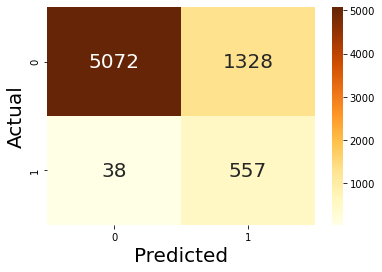

In [38]:
DT(sfm_lr_bad)

In [39]:
# SVM(sfm_lr_bad, 'rbf')

In [40]:
# XGB(sfm_lr_bad)

##### Permutation Importance

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8563508162866361

예측 데이터 정확도
accuracy score : 0.790
precision score : 0.271
recall score : 0.867
f1 score : 0.413
roc score : 0.825
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.49378    0.14195 0.98151   0.24804    0.71498
0.30000   0.62616    0.18018 0.95630   0.30322    0.77589
0.40000   0.72552    0.22680 0.92437   0.36424    0.81570
0.50000   0.79028    0.27101 0.86723   0.41297    0.82518
0.60000   0.83660    0.31051 0.75462   0.43998    0.79942
0.70000   0.86405    0.32685 0.56471   0.41405    0.72829
0.80000   0.87977    0.31135 0.34118   0.32558    0.63551
0.90000   0.89378    0.25497 0.12941   0.17168    0.54713
None


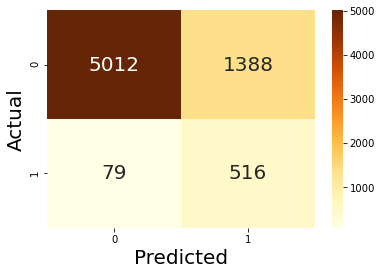

In [41]:
LR(sfm_pi_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9089888277120519

예측 데이터 정확도
accuracy score : 0.846
precision score : 0.341
recall score : 0.872
f1 score : 0.491
roc score : 0.858
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.81401    0.30668 0.94118   0.46262    0.87168
0.30000   0.81615    0.30922 0.94118   0.46550    0.87285
0.40000   0.83803    0.33354 0.90588   0.48756    0.86880
0.50000   0.84589    0.34122 0.87227   0.49055    0.85785
0.60000   0.85990    0.35793 0.81513   0.49744    0.83959
0.70000   0.87091    0.36701 0.71429   0.48488    0.79988
0.80000   0.88420    0.36842 0.50588   0.42635    0.71263
0.90000   0.89793    0.39083 0.35798   0.37368    0.65305
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

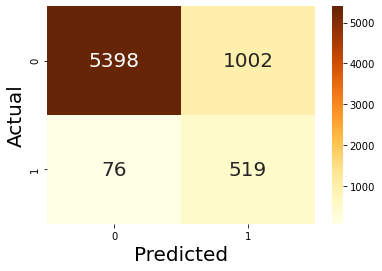

In [42]:
DT(sfm_pi_bad)

In [43]:
# SVM(sfm_pi_bad, 'rbf')

In [44]:
# XGB(sfm_pi_bad)